[A Step-By-Step Guide to Implementing the SuperTrend Indicator in Python](https://medium.com/codex/step-by-step-implementation-of-the-supertrend-indicator-in-python-656aa678c111)

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
import yfinance as yf

stk = yf.Ticker('spy')
# 取得 1995 年至今的資料
data = stk.history(start = '2020-01-01')
# 簡化資料，只取開、高、低、收以及成交量
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = ['open','high','low','close','volume']

In [51]:
import pandas as pd
from talib import abstract

# 隨意試試看這幾個因子好了 [指數平滑異同移動平均線, 相對強弱指數, 運動量指標, KD指標]
# ta_list = ['MACD','RSI','MOM','STOCH']
# 快速計算與整理因子
# for x in ta_list:
#     output = eval('abstract.'+x+'(data)')
#     output.name = x.lower() if type(output) == pd.core.series.Series else None
#     data = pd.merge(data, pd.DataFrame(output), left_on = data.index, right_on = output.index)
#     data = data.set_index('key_0')

#### Supertrend 指標 介紹

**計算真實範圍（TR）**：資產的真實範圍是通過取三個價格差異的最大值來計算的：<br>
市場最高價減去標記最低價，市場最高價減去前一個市場收盤價，前一個市場收盤價減去市場最低價。它可以表示如下：<br>
<code>MAX [ { HIGH - LOW }, { HIGH - P.CLOSE }, { P.CLOSE - LOW } ]其中，<br> MAX = 最大值
HIGH = 市場高點 <br>
LOW = 市場低點<br>
P.CLOSE = 前一個市場收盤價</code>

**計算 ATR**：平均真實範圍的計算很簡單。我們只需對指定週期數的先前計算的真實範圍值進行平滑平均即可。平滑平均值不僅僅是任何 SMA 或 EMA，而是 Wilder Wiles 自己創建的一種自己的平滑平均值，但使用其他 MA 也沒有任何限制。在本文中，我們將使用指數移動平均線 (EMA) 來計算 ATR，而不是指標創建者創建的自定義移動平均線，只是為了讓事情變得簡單。傳統設置為 14 作為周期數的 ATR 的計算可以表示如下：<br>
<code>ATR 14 = EMA 14 [ TR ]

其中 <br>
ATR 14 = 14 週期平均真實範圍 <br>
SMA 14 = 14 週期簡單移動平均線 <br>
TR = 真實範圍</code>

### 正式開始 編輯supertrend

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [53]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt

In [54]:
data['st'], data['s_upt'], data['st_dt'] = get_supertrend(data['high'], data['low'], data['close'], 34, 3)
data = data[1:]
data.head()

,open,high,low,close,volume,st,s_upt,st_dt
Date,,,,,,,,
2020-01-02,311.116104,312.414270,310.144879,312.395020,59151200,318.528029,NaN,318.528029
2020-01-03,308.827510,311.212289,308.769817,310.029510,77709700,318.483770,NaN,318.483770
2020-01-06,308.183247,311.298851,308.058234,311.212311,55653900,318.483770,NaN,318.483770
2020-01-07,310.616062,311.116113,309.866015,310.337219,40496400,318.293484,NaN,318.293484
2020-01-08,310.539185,313.270126,310.279564,311.991211,68296000,318.293484,NaN,318.293484


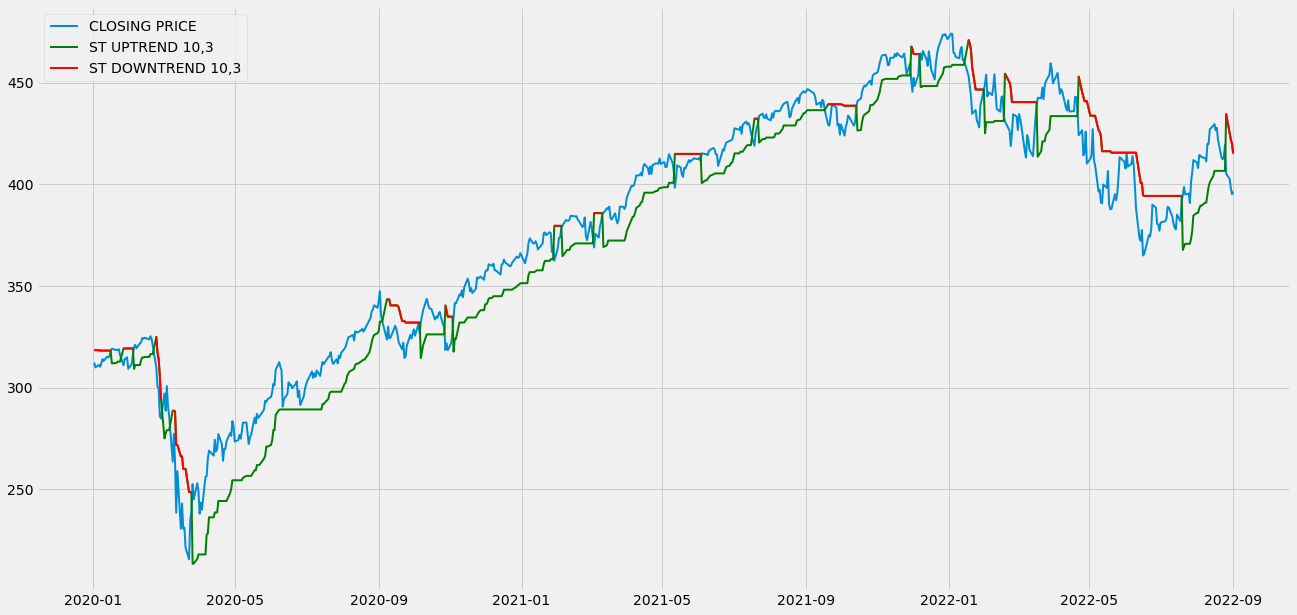

In [55]:
plt.plot(data['close'], linewidth = 2, label = 'CLOSING PRICE')
plt.plot(data['st'], color = 'green', linewidth = 2, label = 'ST UPTREND 10,3')
plt.plot(data['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND 10,3')
plt.legend(loc = 'upper left')
plt.show()

In [56]:
def implement_st_strategy(prices, st):
    buy_price = []
    sell_price = []
    st_signal = []
    signal = 0
    
    for i in range(len(st)):
        if st[i-1] > prices[i-1] and st[i] < prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                st_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        elif st[i-1] < prices[i-1] and st[i] > prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                st_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            st_signal.append(0)
            
    return buy_price, sell_price, st_signal

buy_price, sell_price, st_signal = implement_st_strategy(data['close'], data['st'])

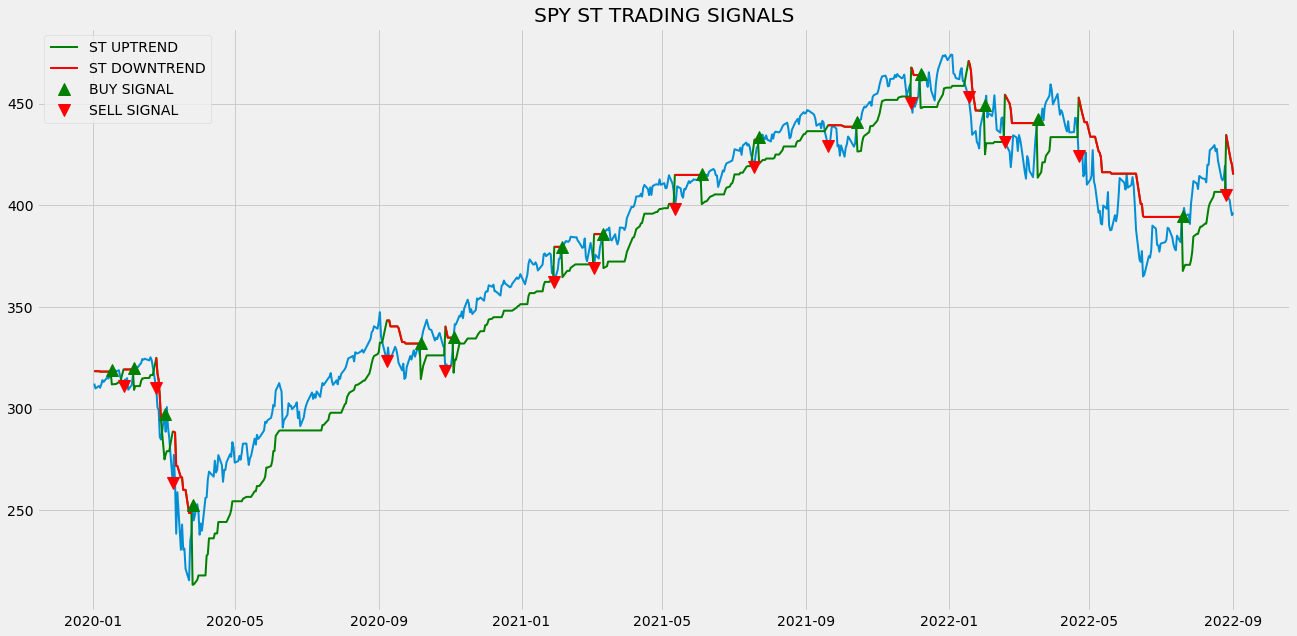

In [57]:
plt.plot(data['close'], linewidth = 2)
plt.plot(data['st'], color = 'green', linewidth = 2, label = 'ST UPTREND')
plt.plot(data['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND')
plt.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(data.index, sell_price, marker = 'v', color = 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.title('SPY ST TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [58]:
position = []
for i in range(len(st_signal)):
    if st_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(data['close'])):
    if st_signal[i] == 1:
        position[i] = 1
    elif st_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = data['close']
st = data['st']
st_signal = pd.DataFrame(st_signal).rename(columns = {0:'st_signal'}).set_index(data.index)
position = pd.DataFrame(position).rename(columns = {0:'st_position'}).set_index(data.index)

frames = [close_price, st, st_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,st,st_signal,st_position
Date,,,,
2020-01-02,312.395020,318.528029,0,1
2020-01-03,310.029510,318.483770,0,1
2020-01-06,311.212311,318.483770,0,1
2020-01-07,310.337219,318.293484,0,1
2020-01-08,311.991211,318.293484,0,1
...,...,...,...,...
2022-08-26,405.309998,434.712992,-1,0
2022-08-29,402.630005,425.394056,0,0
2022-08-30,398.209991,421.993368,0,0


In [59]:
tsla_ret = pd.DataFrame(np.diff(data['close'])).rename(columns = {0:'returns'})
st_strategy_ret = []

for i in range(len(tsla_ret)):
    returns = tsla_ret['returns'][i]*strategy['st_position'][i]
    st_strategy_ret.append(returns)
    
st_strategy_ret_df = pd.DataFrame(st_strategy_ret).rename(columns = {0:'st_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/data['close'][-1])
st_investment_ret = []

for i in range(len(st_strategy_ret_df['st_returns'])):
    returns = number_of_stocks*st_strategy_ret_df['st_returns'][i]
    st_investment_ret.append(returns)

st_investment_ret_df = pd.DataFrame(st_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(st_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the ST strategy by investing $100k in TSLA : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the ST strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the ST strategy by investing $100k in TSLA : 3169.83
Profit percentage of the ST strategy : 3%


In [60]:
def get_benchmark(start_date, investment_value):
    spy = data['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('ST Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

Benchmark profit by investing $100k : 21174.3
Benchmark Profit percentage : 21%
ST Strategy profit is -18% higher than the Benchmark Profit
